In [1]:
import os
abid_dir = os.getcwd()
os.chdir("../..")
main_dir = os.getcwd()
from commons.api.utils import set_to_our_gpus, enable_web_access
set_to_our_gpus()
enable_web_access()

In [2]:
from PIL import Image, ImageDraw
import json
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.transforms import IdentityTransform
from scipy.signal import convolve2d
import torch
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights, ResNet50_Weights, RegNet_Y_16GF_Weights
from torchvision.models import resnet50, resnet18, vgg16, inception_v3

from ultralytics import YOLO

from commons.api.segment_saliency import generate_segmentation_mask, pixels_to_polygon, polygon_to_pixels, generate_saliency_from_polygon, plot_polygon
from commons.api.imagenet_tiny import get_imagenet_classes, get_random_images
from commons.api.vit import load_vit
from commons.api.viz import visualize_saliency_overlay
from commons.api.method.attention_rollout import rollout, grad_rollout, vit_saliency_map
from commons.api.metric.ior import insalient_outsalient_ratio
from commons.api.method.adv_perturb import adversarial_noise, FGSM_MOD
from commons.api.method.attribution import attribution

from cam import CAM, ScoreCAM, GradCAM, GradCAMpp, SmoothGradCAMpp


os.chdir("abid/ior_analysis")
vit_model = load_vit()

yolo_model = YOLO('yolov8m-seg.pt')

def generate_yolo_segmentation_mask(model, img_input):
    results = model(img_input)
    if results[0].masks != None:
        return np.array(Image.fromarray(results[0].masks.cpu().data[0].numpy()).resize((224, 224)))
    else:
        return results[0].masks
    
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

resnet_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)
resnet_model.eval();
target_layer = resnet_model.layer4[1].conv2

resnet_transform = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

scorecam_wrapped_model = ScoreCAM(resnet_model, target_layer)

def get_imagenet_classes(): 
    classes_json = "../../data/imagenet_class_index.json"
    classes = json.load(open(classes_json))
    classes = np.array(list(classes.values()))
    return classes[:, 1]

classes = get_imagenet_classes()

ground_saliencies = np.load('../data/ground_saliency_images/ground_saliencies_2_fixed.npy')
images = np.load('../data/ground_saliency_images/images_2_fixed.npy')
obj_masks = np.load('../data/ground_saliency_images/obj_masks_2_fixed.npy')


def insalient_outsalient_ratio_new(reference, comparative, object_mask):
    assert(reference.shape == comparative.shape)
    agreement = reference * comparative

    epsilon = 1e-8
    insalient_agreement = (agreement * object_mask) + epsilon
    # insalient_agreement_norm = insalient_agreement / insalient_agreement.max()
    # insalient_agreement_norm = np.where(insalient_agreement_norm >= 0.9, 1, insalient_agreement_norm)

    reference_distribution = reference + epsilon
    reference_distribution = reference_distribution / reference_distribution.sum()
    
    reference_in_distribution = (reference_distribution * object_mask)

    # Expect in-saliency agreement to be in the same place. Also the value that is concentrated in the reference must be the one with greatest agreement as well.
    insalient = np.sum(insalient_agreement * reference_in_distribution)

    # expect the saliency outside mask to be spurious and spread out and therefore, not coincide with each other in both saliencies
    outsalient_agreement = (reference * np.logical_not(object_mask).astype(float)) + epsilon
    # outsalient_agreement_norm = outsalient_agreement / outsalient_agreement.max()
    # outsalient_agreement_norm = np.where(outsalient_agreement_norm >= 0.9, 1, outsalient_agreement_norm)

    reference_out_distribution = reference_distribution * np.logical_not(object_mask).astype(float)

    # out-salient distribution must also not have large values
    outsalient = np.sum(outsalient_agreement * reference_out_distribution)

    return insalient/ (outsalient + insalient)


def ior_singluar(saliency, object_mask):
    epsilon = 1e-9
    inner_saliency = (saliency * object_mask) + epsilon
    outer_saliency = saliency * np.logical_not(object_mask).astype(float)
    
    return np.sum(inner_saliency) / (np.sum(inner_saliency) + np.sum(outer_saliency))



def text_to_rgba(s, *, dpi, **kwargs):
    # To convert a text string to an image, we can:
    # - draw it on an empty and transparent figure;
    # - save the figure to a temporary buffer using ``bbox_inches="tight",
    #   pad_inches=0`` which will pick the correct area to save;
    # - load the buffer using ``plt.imread``.
    #
    # (If desired, one can also directly save the image to the filesystem.)
    fig = Figure(facecolor="none", figsize=(10, 10))
    fig.text(0, 0, s, **kwargs)
    with BytesIO() as buf:
        fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight",
                    pad_inches=0)
        buf.seek(0)
        rgba = plt.imread(buf)
    return rgba

Using cache found in /home/hashimi/.cache/torch/hub/facebookresearch_deit_main


In [3]:
def apply_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.copy(image)
    patched_image[top_left_y : top_left_y+patch_size,
                  top_left_x : top_left_x+patch_size, :] = 0
    return patched_image

In [4]:
def generate_img_occlusion_list(img, saliency, patch_size, saliency_reduce_func=np.mean):
    occlusion_img_list = []
    occlusion_saliency_statistic = []
    saliency = np.array(Image.fromarray(saliency).resize((img.shape[0], img.shape[1])))
    
    for top_left_y in range(0, img.shape[1], patch_size):
        for top_left_x in range(0, img.shape[0], patch_size):
            patched_image = apply_patch(img, top_left_x, top_left_y, patch_size).astype('float32') / 255.0
            occlusion_img_list.append(patched_image)
            occlusion_saliency_statistic.append(saliency_reduce_func(saliency[top_left_y : top_left_y+patch_size,
                                                                              top_left_x : top_left_x+patch_size]))
            
    return np.array(occlusion_img_list), np.array(occlusion_saliency_statistic)

def generate_img_occlusion_list_no_saliency(img, patch_size):
    occlusion_img_list = []
    occlusion_saliency_statistic = []
    
    for top_left_y in range(0, img.shape[1], patch_size):
        for top_left_x in range(0, img.shape[0], patch_size):
            patched_image = apply_patch(img, top_left_x, top_left_y, patch_size).astype('float32') / 255.0
            occlusion_img_list.append(patched_image)
            
    return np.array(occlusion_img_list)

In [5]:
def resnet_model_func(img):
    if img.dtype == np.float32 and img.max() <= 1 and img.min() >= 0:
        img = Image.fromarray((img*255).astype(np.uint8))
    else:
        img = Image.fromarray(img)
    input_tensor = resnet_transform(img).unsqueeze(0).to(device)
    resnet_mask, resnet_idx, resnet_probs = scorecam_wrapped_model(input_tensor)
    resnet_mask =  resnet_mask.cpu().numpy().squeeze()
    resnet_probs = resnet_probs.cpu().numpy()
    
    return resnet_mask, resnet_idx, resnet_probs[0]

def occlusion_run_accu_sensitivity(original_image, model_original_mask, model_original_idx, model_original_probs, patch_size, model_func, saliency_reduce_func=np.mean):
    gen_occlu_images, saliency_statistic = generate_img_occlusion_list(original_image, model_original_mask, patch_size, saliency_reduce_func)
    
    saliency_statistic = saliency_statistic**2
    saliency_statistic = saliency_statistic / saliency_statistic.sum()
    x_deltas = (saliency_statistic*100).astype(np.int32)
    
    occluded_run_metric = np.array([])
    for occu_img in gen_occlu_images:
        _, _, model_probs = model_func(occu_img)
        occluded_run_metric = np.append(occluded_run_metric, model_probs[model_original_idx])
    
    scaled_occluded_run_metric = np.repeat(occluded_run_metric, x_deltas)
    
    original_area = model_original_probs[model_original_idx] * np.sum(x_deltas)
    occu_area_integral = []
    for idx in range(1, len(scaled_occluded_run_metric)):
        x_delta = 1.0
        h = abs(scaled_occluded_run_metric[idx] - scaled_occluded_run_metric[idx-1])
        S = min(scaled_occluded_run_metric[idx], scaled_occluded_run_metric[idx-1])
        area = (S + (h/2)) * x_delta
        occu_area_integral.append(area)
        
    score = np.clip(1-(sum(occu_area_integral)/original_area), 0, 1.0)
    return score, x_deltas, scaled_occluded_run_metric, occluded_run_metric

def plot_occlusion_sensitivity(axes, score, x_deltas, scaled_occluded_run_metric, occluded_run_metric, original_probs, original_idx, classes):
    x = np.arange(0, scaled_occluded_run_metric.shape[0], 1)
    y1 = np.repeat(original_probs[original_idx], scaled_occluded_run_metric.shape[0])
    y2 = scaled_occluded_run_metric

    axes[0].plot(x_deltas)
    axes[0].set_title(f"Squared sum of saliency values within occluded patches\n Class: {classes[original_idx]}")
    axes[1].plot(occluded_run_metric, color="red")
    axes[1].plot(np.repeat(original_probs[original_idx], occluded_run_metric.shape[0]) , color="green")
    axes[1].set_title("Accuracy of occluded patches")

    axes[2].fill_between(x, y2, where=(y2 > 0), alpha=0.3, color='red', interpolate=True)
    # plt.fill_between(x, y2, y1, where=(y1 < y2), alpha=0.3, color='green', interpolate=True)
    axes[2].set_ylim(0, 1)
    axes[2].plot(y1)
    axes[2].plot(y2)

    axes[2].text(0, 0+0.07, f"Total area displacement={score:.3f}", fontsize=15, color="white", bbox={'facecolor' : "red", "alpha" : 0.5, "pad" : 5})
    axes[2].set_title("Value for the overall change of area under the curve");
    
def plot_multipatch_occlusion_sensitivity(axes, img, original_mask, original_probs, original_idx, model_func, classes, patch_sizes):
    
    # img = Image.fromarray((img*255).astype(np.uint8))
    visualize_saliency_overlay(axes[0], Image.fromarray(img), original_mask, np.expand_dims(original_probs, 0), original_idx, classes);
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    for idx, patch_size in enumerate(patch_sizes):
        score, x_deltas, scaled_occluded_run_metric, occluded_run_metric = occlusion_run_accu_sensitivity(img, original_mask, original_idx,
                                                                                                          original_probs, patch_size, model_func, np.mean)
        x = np.arange(0, scaled_occluded_run_metric.shape[0], 1)
        y1 = np.repeat(original_probs[original_idx], scaled_occluded_run_metric.shape[0])
        y2 = scaled_occluded_run_metric
        
        axes[1+idx].fill_between(x, y2, where=(y2 > 0), alpha=0.3, color='red', interpolate=True)
        # plt.fill_between(x, y2, y1, where=(y1 < y2), alpha=0.3, color='green', interpolate=True)
        axes[1+idx].set_ylim(0, 1)
        axes[1+idx].plot(y1)
        axes[1+idx].plot(y2)
        axes[1+idx].text(0, 0+0.07, f"Total area displacement={score:.3f}", fontsize=8, color="white", bbox={'facecolor' : "red", "alpha" : 0.5, "pad" : 5})
        axes[1+idx].set_title(f"Area for patch size {patch_size}");

In [6]:
def generate_img_occlusion_list_pos_neg_saliency(img, saliency, patch_size, saliency_reduce_func=np.mean):
    occlusion_img_list = []
    pos_saliency_statistic = []
    neg_saliency_statistic = []
    pos_saliency = np.array(Image.fromarray(saliency).resize((img.shape[0], img.shape[1])))
    neg_saliency = 1 - pos_saliency
    
    for top_left_y in range(0, img.shape[1], patch_size):
        for top_left_x in range(0, img.shape[0], patch_size):
            patched_image = apply_patch(img, top_left_x, top_left_y, patch_size).astype('float32') / 255.0
            occlusion_img_list.append(patched_image)
            pos_saliency_statistic.append(saliency_reduce_func(pos_saliency[top_left_y : top_left_y+patch_size,
                                                                            top_left_x : top_left_x+patch_size]))
            neg_saliency_statistic.append(saliency_reduce_func(neg_saliency[top_left_y : top_left_y+patch_size,
                                                                            top_left_x : top_left_x+patch_size]))
            
    return np.array(occlusion_img_list), np.array(pos_saliency_statistic), np.array(neg_saliency_statistic)

def occlusion_run_accu_sensitivity_v2(original_image, model_original_mask, model_original_idx, model_original_probs, patch_size, model_func, saliency_reduce_func=np.mean):
    gen_occlu_images, pos_saliency_stat, neg_saliency_stat = generate_img_occlusion_list_pos_neg_saliency(original_image, model_original_mask,
                                                                                                          patch_size, saliency_reduce_func)
    # Positive Saliency
    pos_saliency_stat = pos_saliency_stat**2
    pos_saliency_stat = pos_saliency_stat / pos_saliency_stat.sum()
    pos_x_deltas = (pos_saliency_stat*100).astype(np.int32)
    
    occluded_run_metric = np.array([])
    for occu_img in gen_occlu_images:
        model_probs, _ = model_func(occu_img)
        occluded_run_metric = np.append(occluded_run_metric, model_probs[model_original_idx])
    
    pos_scaled_occluded_run_metric = np.repeat(occluded_run_metric, pos_x_deltas)
    
    pos_original_area = model_original_probs[model_original_idx] * np.sum(pos_x_deltas)
    pos_occu_area_integral = []
    for idx in range(1, len(pos_scaled_occluded_run_metric)):
        x_delta = 1.0
        h = np.absolute(pos_scaled_occluded_run_metric[idx] - pos_scaled_occluded_run_metric[idx-1])
        S = np.minimum(pos_scaled_occluded_run_metric[idx], pos_scaled_occluded_run_metric[idx-1])
        area = (S + (h/2)) * x_delta
        pos_occu_area_integral.append(area)
        
    pos_accu_area = sum(pos_occu_area_integral)
        
    # Negative Saliency
    neg_saliency_stat = neg_saliency_stat**2
    neg_saliency_stat = neg_saliency_stat / neg_saliency_stat.sum()
    neg_x_deltas = (neg_saliency_stat*100).astype(np.int32)
    
    neg_scaled_occluded_run_metric = np.repeat(occluded_run_metric, neg_x_deltas)
    
    neg_original_area = model_original_probs[model_original_idx] * np.sum(neg_x_deltas)
    neg_occu_area_integral = []
    for idx in range(1, len(neg_scaled_occluded_run_metric)):
        x_delta = 1.0
        h = np.absolute(neg_scaled_occluded_run_metric[idx] - neg_scaled_occluded_run_metric[idx-1])
        S = np.minimum(neg_scaled_occluded_run_metric[idx], neg_scaled_occluded_run_metric[idx-1])
        area = (S + (h/2)) * x_delta
        neg_occu_area_integral.append(area)
        
    neg_accu_area = sum(neg_occu_area_integral)
    neg_accu_area = np.clip(neg_original_area - neg_accu_area, 0.0, neg_original_area)
    
    # score = np.clip(1-(sum(occu_area_integral)/original_area), 0, 1.0)
    orig_total_area = pos_original_area + neg_original_area
    score = np.clip(1 - ((pos_accu_area + neg_accu_area) / orig_total_area), 0, 1.0)
    
    return score, (pos_x_deltas, pos_scaled_occluded_run_metric, occluded_run_metric), (neg_x_deltas, neg_scaled_occluded_run_metric, occluded_run_metric)

def plot_multipatch_occlusion_sensitivity_v2(axes, img, original_mask, original_probs, original_idx, model_func, classes, patch_sizes, saliency_reduce_func, pos_vs_neg_idx):
    
    # img = Image.fromarray((img*255).astype(np.uint8))
    visualize_saliency_overlay(axes[0], Image.fromarray(img), original_mask, np.expand_dims(original_probs, 0), original_idx, classes);
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    for idx, patch_size in enumerate(patch_sizes):
        score, *values = occlusion_run_accu_sensitivity_v2(img, original_mask, original_idx, original_probs, patch_size, model_func, saliency_reduce_func)
        (x_deltas, scaled_occluded_run_metric, occluded_run_metric) = values[pos_vs_neg_idx]
        x = np.arange(0, scaled_occluded_run_metric.shape[0], 1)
        y1 = np.repeat(original_probs[original_idx], scaled_occluded_run_metric.shape[0])
        y2 = scaled_occluded_run_metric
        
        if pos_vs_neg_idx == 1:
            axes[1+idx].fill_between(x, y2, original_probs[original_idx], where=(y2 < original_probs[original_idx]) , alpha=0.3, color='red', interpolate=True)
        else:
            axes[1+idx].fill_between(x, y2, where=(y2 < original_probs[original_idx]), alpha=0.3, color='red', interpolate=True)
        # plt.fill_between(x, y2, y1, where=(y1 < y2), alpha=0.3, color='green', interpolate=True)
        axes[1+idx].set_ylim(0, 1)
        axes[1+idx].plot(y1)
        axes[1+idx].plot(y2)
        axes[1+idx].text(0, 0+0.07, f"Total area displacement={score:.3f}", fontsize=8, color="white", bbox={'facecolor' : "red", "alpha" : 0.5, "pad" : 5})
        axes[1+idx].set_title(f"Area for patch size {patch_size}");

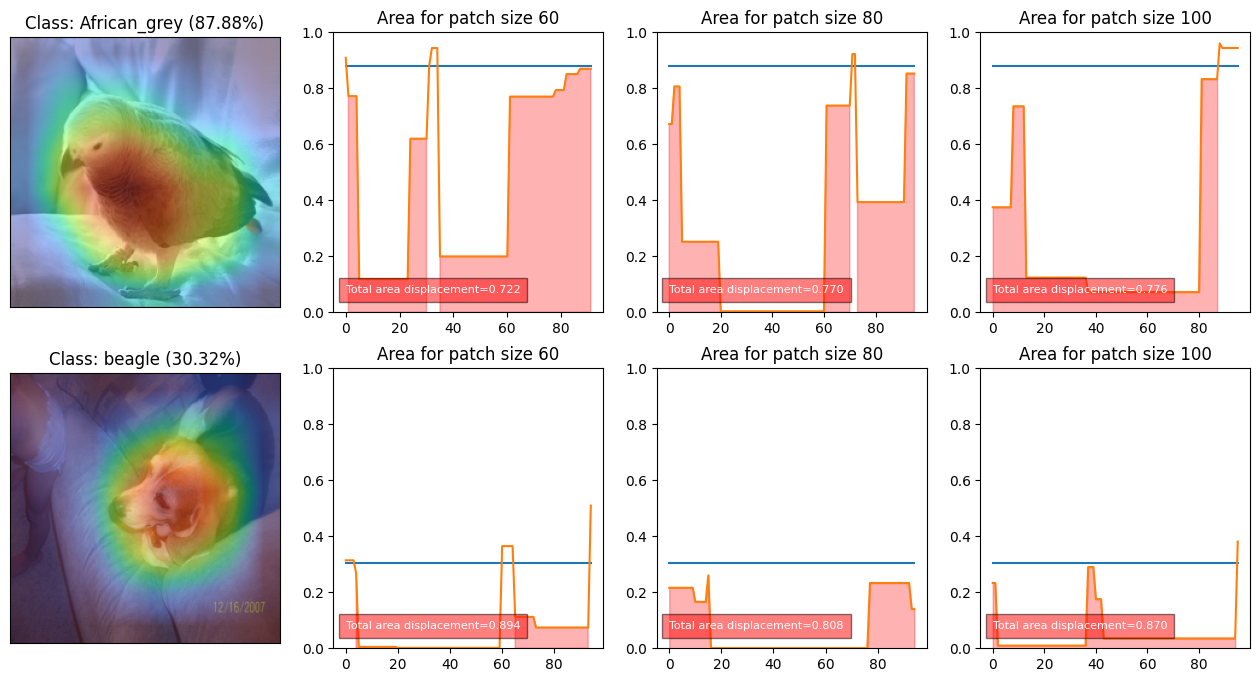

In [22]:
num_images = 2
offset = 6
patch_sizes = [60, 80, 100]

fig, axes = plt.subplots(ncols=1+len(patch_sizes), nrows=num_images)
fig.set_figheight(4*num_images)
fig.set_figwidth(4*(1+len(patch_sizes)))
    
for idx in range(num_images):
    original_mask, original_idx, original_probs = resnet_model_func(images[idx+offset])
    plot_multipatch_occlusion_sensitivity_v2(axes[idx], images[idx+offset], original_mask, original_probs, original_idx, resnet_model_func, classes, patch_sizes, np.mean, 0)

In [7]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
resnet50_model = resnet50(pretrained=True).to(device).eval()
resnet50_target_layer = "layer4.1"

/scratch/hashimi/python/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/hashimi/python/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
def get_conv_saliencies(in_ten, model, target_layer):
    grad_cam, grad_idx, grad_probs = attribution(model, in_ten, "GradCAM", resnet50_target_layer)
    score_cam, score_idx, score_probs = attribution(model, in_ten, "ScoreCAM", resnet50_target_layer)   
    smoothgradpp_cam, smoothgradpp_idx, smoothgradpp_probs = attribution(model, in_ten, "SmoothGradCAMpp", resnet50_target_layer)
    layer_cam, layer_idx, layer_probs = attribution(model, in_ten, "LayerCAM", resnet50_target_layer)
    techniques = {"GradCAM" :         grad_cam,
                  "ScoreCAM":         score_cam,
                  "SmoothGradCAMpp":  smoothgradpp_cam,
                  "LayerCAM":         layer_cam}
    
    return techniques, grad_probs, grad_idx

In [12]:
# Shape: (img, techniques, patch_size 40, 60, 80, 100)
occu_sen = np.empty((100, 4, 4))

In [34]:
# classes

in_ten = transform(Image.fromarray(images[0])).to(device).unsqueeze(0)
probs = resnet50_model(in_ten).squeeze().detach().cpu().numpy()
probs.shape

(1000,)

In [62]:
resnet50_model_func(images[0])[0].shape

(1000,)

In [11]:
def resnet50_model_func(img):
    if img.dtype == np.float32 and img.max() <= 1 and img.min() >= 0:
        img = Image.fromarray((img*255).astype(np.uint8))
    else:
        img = Image.fromarray(img)
    in_ten = transform(img).to(device).unsqueeze(0)
    probs = torch.nn.functional.softmax(resnet50_model(in_ten).squeeze().detach(), dim=0).cpu().numpy()
    return probs, probs.argmax()

In [13]:
import time
tic = time.perf_counter()

for img_idx, img in enumerate(images):
    in_ten = transform(Image.fromarray(img)).to(device)
    saliencies, original_probs, original_idx = get_conv_saliencies(in_ten, resnet50_model, resnet50_target_layer)
    tech_names = list(saliencies.keys())
    
    gradcam = saliencies[tech_names[0]]
    scorecam = saliencies[tech_names[1]]
    smoothcam = saliencies[tech_names[2]]
    layercam = saliencies[tech_names[3]]
    
    # GradCAM
    score, *values = occlusion_run_accu_sensitivity_v2(img, gradcam, original_idx, original_probs[0],
                                                       40, resnet50_model_func, np.mean)
    occu_sen[img_idx, 0, 0] = score
    score, *values = occlusion_run_accu_sensitivity_v2(img, gradcam, original_idx, original_probs[0],
                                                       60, resnet50_model_func, np.mean)
    occu_sen[img_idx, 0, 1] = score
    score, *values = occlusion_run_accu_sensitivity_v2(img, gradcam, original_idx, original_probs[0],
                                                       80, resnet50_model_func, np.mean)
    occu_sen[img_idx, 0, 2] = score
    score, *values = occlusion_run_accu_sensitivity_v2(img, gradcam, original_idx, original_probs[0],
                                                       100, resnet50_model_func, np.mean)
    occu_sen[img_idx, 0, 3] = score
    
    # ScoreCAM
    score, *values = occlusion_run_accu_sensitivity_v2(img, scorecam, original_idx, original_probs[0],
                                                       40, resnet50_model_func, np.mean)
    occu_sen[img_idx, 1, 0] = score
    score, *values = occlusion_run_accu_sensitivity_v2(img, scorecam, original_idx, original_probs[0],
                                                       60, resnet50_model_func, np.mean)
    occu_sen[img_idx, 1, 1] = score
    score, *values = occlusion_run_accu_sensitivity_v2(img, scorecam, original_idx, original_probs[0],
                                                       80, resnet50_model_func, np.mean)
    occu_sen[img_idx, 1, 2] = score
    score, *values = occlusion_run_accu_sensitivity_v2(img, scorecam, original_idx, original_probs[0],
                                                       100, resnet50_model_func, np.mean)
    occu_sen[img_idx, 1, 3] = score
    
    # SmoothGradCAM++
    score, *values = occlusion_run_accu_sensitivity_v2(img, smoothcam, original_idx, original_probs[0],
                                                       40, resnet50_model_func, np.mean)
    occu_sen[img_idx, 2, 0] = score
    score, *values = occlusion_run_accu_sensitivity_v2(img, smoothcam, original_idx, original_probs[0],
                                                       60, resnet50_model_func, np.mean)
    occu_sen[img_idx, 2, 1] = score
    score, *values = occlusion_run_accu_sensitivity_v2(img, smoothcam, original_idx, original_probs[0],
                                                       80, resnet50_model_func, np.mean)
    occu_sen[img_idx, 2, 2] = score
    score, *values = occlusion_run_accu_sensitivity_v2(img, smoothcam, original_idx, original_probs[0],
                                                       100, resnet50_model_func, np.mean)
    occu_sen[img_idx, 2, 3] = score
    
    # LayerCAM
    score, *values = occlusion_run_accu_sensitivity_v2(img, layercam, original_idx, original_probs[0],
                                                       40, resnet50_model_func, np.mean)
    occu_sen[img_idx, 3, 0] = score
    score, *values = occlusion_run_accu_sensitivity_v2(img, layercam, original_idx, original_probs[0],
                                                       60, resnet50_model_func, np.mean)
    occu_sen[img_idx, 3, 1] = score
    score, *values = occlusion_run_accu_sensitivity_v2(img, layercam, original_idx, original_probs[0],
                                                       80, resnet50_model_func, np.mean)
    occu_sen[img_idx, 3, 2] = score
    score, *values = occlusion_run_accu_sensitivity_v2(img, layercam, original_idx, original_probs[0],
                                                       100, resnet50_model_func, np.mean)
    occu_sen[img_idx, 3, 3] = score
    
    print(img_idx)
    if img_idx >= 100:
        break
toc = time.perf_counter()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


IndexError: index 100 is out of bounds for axis 0 with size 100

In [9]:
(toc - tic)*100/60

31.35143569825838

In [15]:
np.save("occu_sen_tech_all_patch_40_60_80_100", occu_sen)

In [17]:
occu_sen.shape

(100, 4, 4)

In [42]:
# Patch 40
occu_sen[:, :, 3].std(0)

array([    0.13028,    0.088322,    0.071105,     0.12692])